# Import Statements



In [ ]:
#Machine Learning
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2
from torchvision.utils import save_image

#Data
import os
import pandas as pd
import tarfile
from operator import itemgetter

#Data Visualization
import matplotlib.pyplot as plt

#Upload to Google Drive
import shutil
import pickle

#Mount Google Drive for saving and retreiving .npy files to them
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

#Global Variables
claire = 'APS360_Team_11_Project_Folder'
sean = 'University/Third_Year/APS360/APS360_Project'
charlotte = ''
thardchi = 'APS360'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Previously Saved Images from Numpy Arrays

In [ ]:
#Please replace the variable with your custom path when you want to run the notebook
labels = np.load('/content/IntensityRatings.npy', allow_pickle=True)
images= np.load('/content/drive/MyDrive/Copy of Images.npy', allow_pickle=True)

# Transform the data into Tensor Datasets

In [ ]:
#Here, our pixel values were in range [0, some big number] -> make them between 0 and 1
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
new_images = rescale(images)

#Create a dictionary of image-label key value pairs (We need this to create a custom dataset)
image_data = []
for i in range(0, 2563):
  dictionary = {}
  dictionary['image'] = new_images[i]
  dictionary['label'] = labels[i]
  image_data.append(dictionary)

#Define our transforms
simple = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Resize((301, 301)),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])

#Define the custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        item = self.data[index]
        image = item['image']
        if self.transform:
            image = self.transform(image)
        label = item['label']
        return image, label

#Create the master custom dataset
my_dataset = CustomDataset(image_data, transform=simple)

# Save all Images with training labels to Drive

In [ ]:
for i in range(len(my_dataset)):
  img, label = my_dataset[i]
  plt.axis('off')
  plt.imshow(img.squeeze())
  plt.savefig('/content/drive/MyDrive/data_for_hurriscan/{}_class={}.png'.format(i,label), bbox_inches='tight')

At this point, Charlotte manually put each image into a folder specified by class

# Loading the Master Dataset

In [ ]:
!unzip '/content/drive/MyDrive/APS360_Team_11_Project_Folder/ProgressReportDataFolderLabelled_v2.zip' -d '/root/datasets'
source_dir = '/root/datasets/ProgressReportDataFolderLabelled_v2'  # defining our source directory

In [ ]:
#Define our transforms
simple = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((224, 224), antialias=True)
])
master_dataset = torchvision.datasets.ImageFolder(root=source_dir, transform=simple)

# Loading and Splitting the Image Dataset

Here, we split the master dataset into training, testing, and validation datasets that we save in our shared google drive.



In [ ]:
!pip install split-folders

In [ ]:
# defining data directory
data_dir = '/content/drive/MyDrive/APS360 Project/HurriScan_Data/ProgresReportData/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
val_dir = os.path.join(data_dir, 'val/')

# split the data into train, test, and validation sets with a 40-40-40 split
splitfolders.ratio(source_dir, output=data_dir, seed=1337, ratio=(0.4, 0.4, 0.2))

# Loading the Training/Validation/Testing Datasets

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root=f'/content/drive/MyDrive/{claire}/HurriScan_Data/ProgressReportData/train', transform=simple)
validation_dataset = torchvision.datasets.ImageFolder(root=f'/content/drive/MyDrive/{claire}/HurriScan_Data/ProgressReportData/val', transform=simple)
test_dataset = torchvision.datasets.ImageFolder(root=f'/content/drive/MyDrive/{claire}/HurriScan_Data/ProgressReportData/test', transform=simple)

# Visualize Some of The Data and Labels

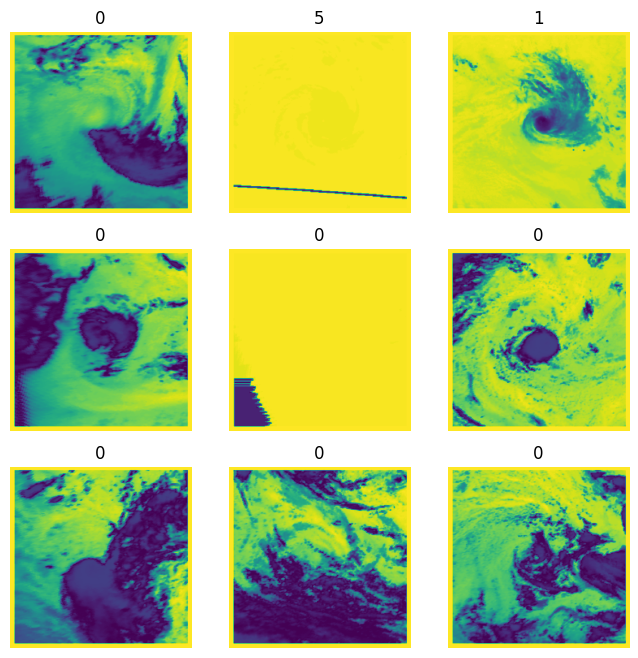

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(master_dataset), size=(1,)).item()
    img, label = master_dataset[sample_idx]
    #img = simple(img)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img[0])
plt.show()

## Plot of Categorical Distributions in the Entire Dataset

Class Label:  0 Number of Instances:  1898
Class Label:  1 Number of Instances:  386
Class Label:  2 Number of Instances:  121
Class Label:  3 Number of Instances:  72
Class Label:  4 Number of Instances:  71
Class Label:  5 Number of Instances:  15


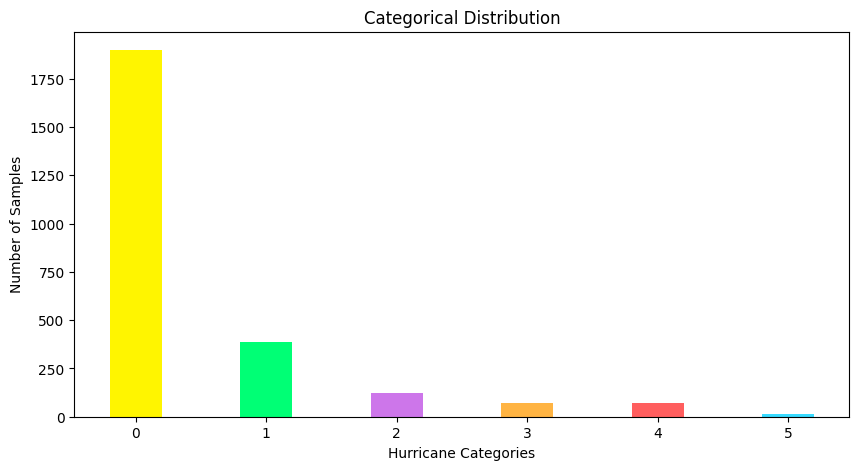

In [ ]:
from collections import Counter
def plot_categories(dataset):
  labels_unique = [sample[1] for sample in dataset]
  label_counts = Counter(labels_unique)
  data = {}
  for label, count in label_counts.items():
      data[label] = count
      print("Class Label: ", label, "Number of Instances: ", count)
  labels_for_graph = list(data.keys())
  counts = list(data.values())
  c = ['#fff500', '#00ff75', '#cd76ea', '#ffb443', '#ff5e5e', '#39dbff']
  fig = plt.figure(figsize = (10, 5))
  plt.bar(labels_for_graph, counts, color =c, width = 0.4)
  plt.xlabel("Hurricane Categories")
  plt.ylabel("Number of Samples")
  plt.title("Categorical Distribution of Classes in Entire Dataset")
  plt.show()

plot_categories(master_dataset)

# Visualize Class Distributions Among training/validation/testing Datasets

<Figure size 2500x1000 with 0 Axes>

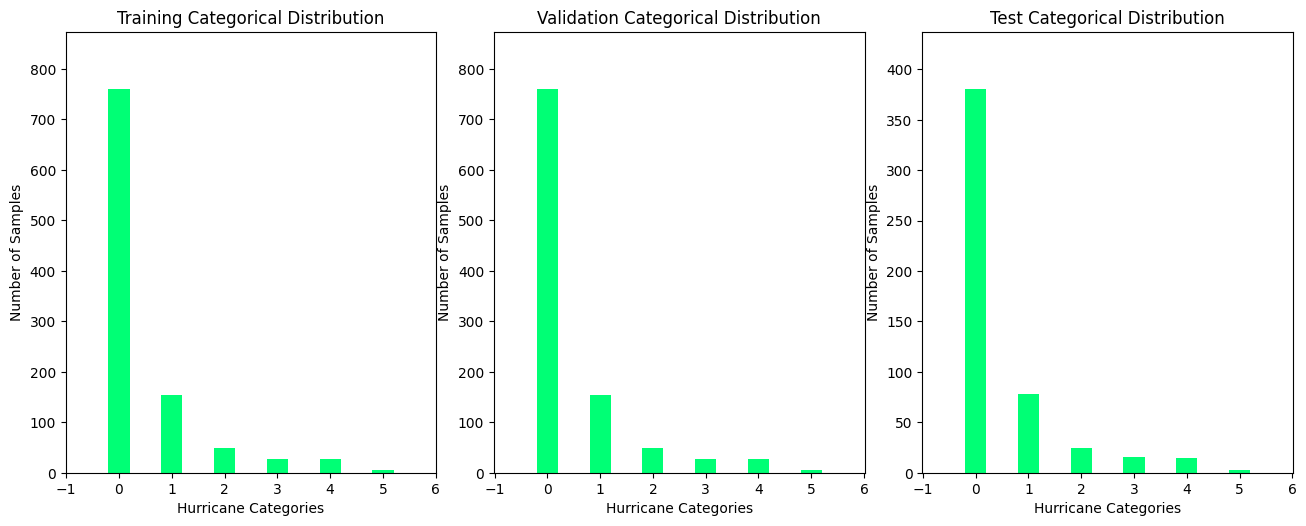

In [ ]:
dataset_indices = [train_dataset, validation_dataset, test_dataset]
titles = ["Training Categorical Distribution", "Validation Categorical Distribution", "Test Categorical Distribution"]
figure = plt.figure(figsize=(25, 10))
cols, rows = 3, 1
fig, ax = plt.subplots(1, 3, figsize=(13,5))
fig.tight_layout()
for i in range(0, cols*rows):
    data = {}
    plottable_dataset = dataset_indices[i]
    labels_unique = [sample[1] for sample in plottable_dataset]
    label_counts = Counter(labels_unique)
    for label, count in label_counts.items():
      data[label] = count
    labels_for_graph = list(data.keys())
    counts = list(data.values())
    ax[i].margins(0.15) # 15% padding in all directions
    c = ['#00ff75']
    ax[i].set_xlabel("Hurricane Categories")
    ax[i].bar(labels_for_graph, counts, color =c, width = 0.4)
    ax[i].set_ylabel("Number of Samples")
    ax[i].set_title(titles[i])
    fig.show()